In [244]:
%load_ext autoreload
%autoreload 2

import splitwavepy as sw
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from scipy import signal

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


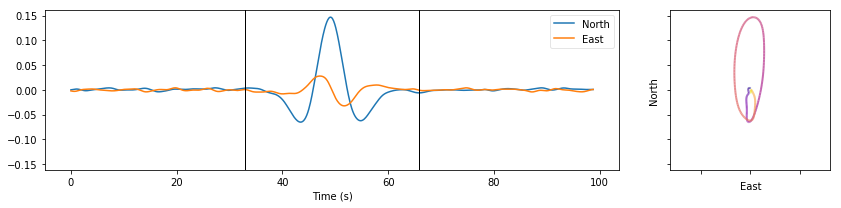

In [194]:
a = sw.SplitWave(split=(30,1.2), noise=0.01)
a.plot()

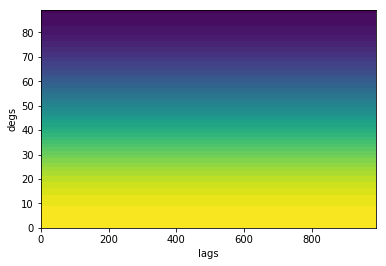

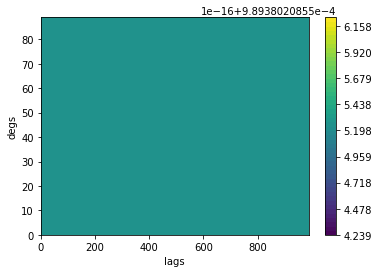

In [345]:
# apply taper to data
win = signal.tukey(a.x.size, alpha=0.9)
x = win * a.x
y = win * a.y

cov = sw.core.core.gridcovfreq(x, y, b._ndegs, b._nlags)
shp = cov.shape
l0 = np.arange(shp[0])
d0 = np.arange(shp[1])
dd, ll = np.meshgrid(l0, d0, indexing='ij')

# rho = sw.core.core.covmap2rho(cov)
# plt.contourf( dd, ll, np.abs(rho), 50)
# plt.xlabel('lags')
# plt.ylabel('degs')
# plt.show()

# lam1, lam2 = sw.core.core.covmap2eigvals(cov)
# plt.contourf( dd, ll, lam1/lam2, 50)
# plt.xlabel('lags')
# plt.ylabel('degs')
# plt.show()

sig1 = cov[:,:,0,0]
plt.contourf( dd, ll, sig1, 50)
plt.xlabel('lags')
plt.ylabel('degs')
plt.show()

sig2 = cov[:,:,1,1]
plt.contourf( dd, ll, sig1 + sig2, 50)
plt.xlabel('lags')
plt.ylabel('degs')
plt.colorbar()
plt.show()

In [338]:
i, j = 34, 60

print(np.linalg.eigvalsh(cov[i,j]))
lam1, lam2 = sw.core.core.covmap2eigvals(cov)
print(lam1[i,j], lam2[i,j])

[ 0.00022654  0.00076284]
0.000762844196061 0.000226536012489


In [339]:
cov[0,:,0,0]

array([  9.32623107e-04,   9.33309461e-04,   9.33461426e-04,
         9.33078815e-04,   9.32162094e-04,   9.30712382e-04,
         9.28731444e-04,   9.26221693e-04,   9.23186187e-04,
         9.19628625e-04,   9.15553341e-04,   9.10965300e-04,
         9.05870091e-04,   9.00273923e-04,   8.94183614e-04,
         8.87606583e-04,   8.80550844e-04,   8.73024994e-04,
         8.65038200e-04,   8.56600194e-04,   8.47721257e-04,
         8.38412206e-04,   8.28684382e-04,   8.18549637e-04,
         8.08020320e-04,   7.97109258e-04,   7.85829745e-04,
         7.74195523e-04,   7.62220767e-04,   7.49920066e-04,
         7.37308406e-04,   7.24401153e-04,   7.11214033e-04,
         6.97763112e-04,   6.84064778e-04,   6.70135720e-04,
         6.55992908e-04,   6.41653574e-04,   6.27135187e-04,
         6.12455437e-04,   5.97632207e-04,   5.82683559e-04,
         5.67627704e-04,   5.52482985e-04,   5.37267855e-04,
         5.22000851e-04,   5.06700573e-04,   4.91385661e-04,
         4.76074776e-04,

In [346]:
cov = sw.core.core.gridcovfreq(a.x, a.y, b._ndegs, b._nlags)
cov.shape
mlags = int(b._nlags*2) - 1
l0 = np.linspace(-b._maxlag, b._maxlag, mlags)
mdegs = int(b._ndegs/2)
d0 = np.linspace(0, 90, mdegs, endpoint=False)
dd, ll = np.meshgrid(l0, d0, indexing='ij')

rho = sw.core.core.covmap2rho(cov)
plt.contourf( dd, ll, np.abs(rho), 50)
plt.xlabel('lags')
plt.ylabel('degs')
plt.show()

lam1, lam2 = sw.core.core.covmap2eigvals(cov)
plt.contourf( dd, ll, lam1/lam2, 50)
plt.xlabel('lags')
plt.ylabel('degs')
plt.show()

TypeError: Shape of x does not match that of z: found (165, 90) instead of (989, 90).

In [347]:
cov.shape[0]

989

In [220]:
def covfreq_reshape(cov):
    """Reshape a covariance map output using the Fourier method to match the standard."""
    shp = cov.shape
    mid = int((shp[0]-1)/2)
    neg = cov[:mid+1,:,:,:]
    pos = cov[mid:,:,:,:]
    neg = np.flip(neg, 0)
    neg = np.flip(neg, 1)
#     pos = np.flip(pos, 1)
    return np.concatenate((neg, pos), axis=1)    

In [348]:
covrs = covfreq_reshape(cov)

In [349]:
ll, dd = b._grid
rho = sw.core.core.covmap2rho(covrs)
lam1, lam2 = sw.core.core.covmap2eigvals(covrs)

plt.contourf(ll, dd, np.abs(rho), 50)
plt.show()

plt.contourf(ll, dd, lam1/lam2, 50)
plt.show()

TypeError: Shape of x does not match that of z: found (83, 180) instead of (495, 180).

In [124]:
a.x.shape

(989,)

In [125]:
x = a.x
y = a.y
fx = np.fft.fft(x)
fy = np.fft.fft(y)

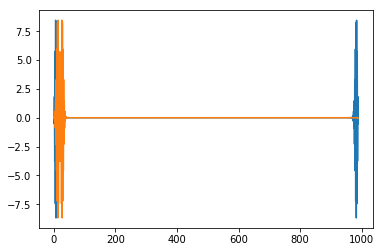

In [87]:
# plt.plot(np.fft.fftshift(fx))
plt.plot(fx.real)
plt.plot(np.roll(fx.real, 20))
plt.show()

In [88]:
np.fft?

In [108]:
rotate = sw.core.core.rotate

def gridcovfreq(x, y, ndegs=90, nslags=50):
    """Returns grid of covariance matrices of shape (ndegs/2, (2*nslags)-1, 2, 2).
       Use covfreq_reshape to get this into a more user friendly shape.
       x and y are the windowed traces.  
       Probably best to use a reasonably long, tapered, window as shifts
       are performed implicitly in the Frequency domain (so wrap around?).
    """
    mdegs = int(ndegs/2)
    mlags = int(nslags*2) - 1
    degs = np.linspace(0, 90, mdegs, endpoint=False)
    n = x.size
    g = np.empty((mlags, mdegs, 2, 2))
    # Fourier Transform
    fx = np.fft.fft(x)
    fy = np.fft.fft(y)
    fx[0] = 0
    fy[0] = 0
    sumsqrs = np.sum(np.abs(fx)**2 + np.abs(fy)**2)
    # now loop and calculate
    for ii in range(mdegs):
        # rotate
        fxr, fyr = rotate(fx, fy, degs[ii])
        # correlate
        cxy = fxr * fyr.conj()
        # inverse transform
        icxy = np.fft.ifft(cxy).real
        # get info
        sumxsqr = np.sum(np.abs(fxr)**2) / n
        sumysqr = (sumsqrs-sumxsqr) / n
        covxy = np.roll(icxy, int(nslags)-1)[0:mlags]
        # basic covariance map
        g[:,ii,0,0] = sumxsqr
        g[:,ii,1,1] = sumysqr
        g[:,ii,0,1] = g[:,ii,1,0] = covxy
    return g / n

In [228]:
a = sw.SplitWave(noise=0.001, split=(30,1.2))
cov = gridcovfreq(a.x, a.y)
cov.shape

(99, 45, 2, 2)

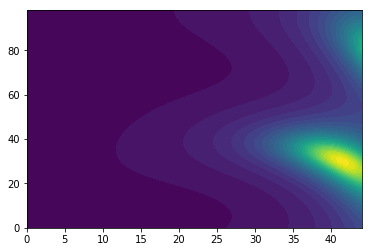

array([[ 0,  1,  2, ..., 42, 43, 44],
       [ 0,  1,  2, ..., 42, 43, 44],
       [ 0,  1,  2, ..., 42, 43, 44],
       ..., 
       [ 0,  1,  2, ..., 42, 43, 44],
       [ 0,  1,  2, ..., 42, 43, 44],
       [ 0,  1,  2, ..., 42, 43, 44]])

In [242]:
shp = cov.shape
aa, bb = np.meshgrid(np.arange(shp[0]), np.arange(shp[1]), indexing='ij')
# aa, bb = np.meshgrid(np.arange(shp[1]), np.arange(shp[0]))
rho = sw.core.core.covmap2rho(cov)
lam1, lam2 = sw.core.core.covmap2eigvals(cov)
plt.contourf(bb, aa, lam1/lam2, 30)
plt.show()
bb


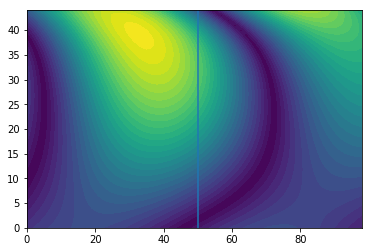

In [237]:
shp = cov.shape
aa, bb = np.meshgrid(np.arange(shp[1]), np.arange(shp[0]))
# stdy = np.sqrt(cov[:, :, 1, 1])
# stdx = np.sqrt(cov[:, :, 0, 0])
# rho = c[:,:,0,1] / (np.sqrt(c[:, :, 1, 1]) * np.sqrt(c[:, :, 0, 0]))
# rho = cov[:,:,0,1] / (stdx * stdy)
rho = sw.core.core.covmap2rho(cov)
plt.contourf(bb, aa, np.abs(rho), 30)
plt.axvline(50)
plt.show()


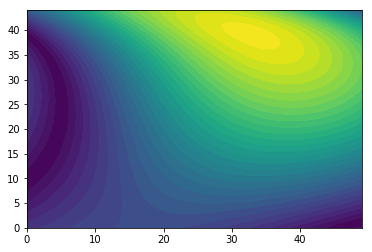

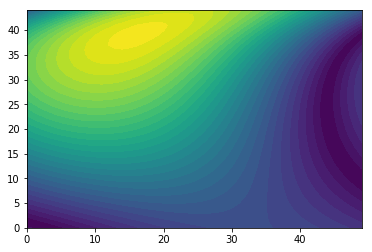

In [236]:
shp = cov.shape
mid = int((shp[0]-1)/2)
pos = cov[:mid+1,:,:,:]
# pos = np.flip(pos, 0)
neg = cov[mid:,:,:,:]
rs = np.concatenate((neg, pos), axis=1)

lam1, lam2 = sw.core.core.covmap2eigvals(pos)
rho = sw.core.core.covmap2rho(pos)
shp = pos.shape
aa, bb = np.meshgrid(np.arange(shp[1]), np.arange(shp[0]))
# plt.contourf(bb, aa, lam1/lam2, 30)
plt.contourf(bb, aa, np.abs(rho), 30)
plt.show()

pos = np.flip(pos, 0)
lam1, lam2 = sw.core.core.covmap2eigvals(pos)
rho = sw.core.core.covmap2rho(pos)
shp = pos.shape
aa, bb = np.meshgrid(np.arange(shp[1]), np.arange(shp[0]))
# plt.contourf(bb, aa, lam1/lam2, 30)
plt.contourf(bb, aa, np.abs(rho), 30)
plt.show()

# lam1, lam2 = sw.core.core.covmap2eigvals(neg)
# rho = sw.core.core.covmap2rho(neg)
# shp = neg.shape
# aa, bb = np.meshgrid(np.arange(shp[1]), np.arange(shp[0]))
# # plt.contourf(bb, aa, lam1/lam2, 30)
# plt.contourf(bb, aa, np.abs(rho), 30)
# plt.show()

# aa, bb = np.meshgrid(np.arange(shp[1]), np.arange(shp[0]))
# plt.contourf(bb, aa, lam1/lam2, 30)
# plt.show()

# shp = rs.shape
# aa, bb = np.meshgrid(np.arange(shp[1]), np.arange(shp[0]))
# rho = sw.core.core.covmap2rho(rs)
# plt.contourf(bb, aa, np.abs(rho), 30)
# plt.show()

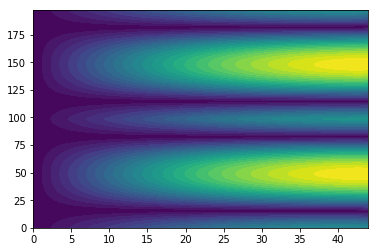

In [225]:
rho = sw.core.core.covmap2rho(cov)
rho2 = np.concatenate((np.flip(rho,0), rho),0)

shp = rho2.shape
aa, bb = np.meshgrid(np.arange(shp[1]), np.arange(shp[0]))

plt.contourf(aa, bb, np.abs(rho2), 30)
plt.show()

In [101]:
shp

(50, 90, 2, 2)

In [153]:
sw.core.core.covmap2rho??

(45, 99, 2, 2)

In [244]:
lags = np.arange(10) * 0.1
degs = np.linspace(0,180,90,endpoint=False)
xx, yy = np.meshgrid(lags, degs, indexing='ij')

In [248]:
xx.shape

(10, 90)

/Users/jackwalpole/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


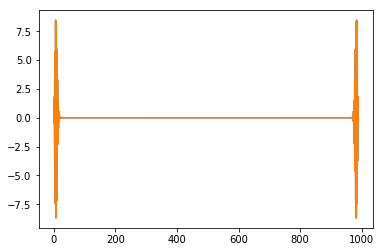

In [128]:
plt.plot(fx)
plt.show()

In [130]:
fx[0]

(0.000168794358194016+0j)

In [137]:
fxs = np.fft.fftshift(fx)

In [144]:
c = np.roll(fx, 49)[0:99]

In [151]:
c[:50].size

50

In [153]:
c[49:].size

50

In [164]:
cov.shape

(165, 90, 2, 2)

In [169]:
np.abs(sw.core.core.covmap2rho(cov)).shape

(165, 90)

In [185]:
np.mean(a.x)
np.mean(a.y)

0.0018015848963097276

In [186]:
x = a.x - np.mean(a.x)
y = a.y - np.mean(a.y)

In [190]:
xx, yy = sw.core.core.rotate(x, y, )
print(np.mean(xx), np.mean(yy))

-2.24514261805e-19 0.0


In [206]:
plt.contourf?

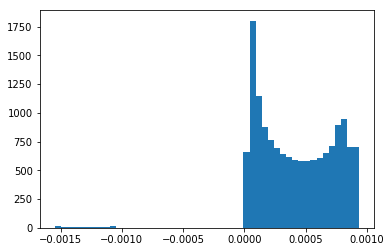

In [216]:
rho = sw.core.core.covmap2rho(cov)
lam1, lam2 = sw.core.core.covmap2eigvals(cov)

plt.hist(np.ravel(lam2),50)
plt.show()

In [360]:
cov0 = sw.core.core.cov_rotate(cov, 0)

In [363]:
cov0[0,:,0,0] + cov0[0,:,1,1]

array([  9.95517806e-04,   9.94911364e-04,   9.93092775e-04,
         9.90064256e-04,   9.85829495e-04,   9.80393654e-04,
         9.73763354e-04,   9.65946673e-04,   9.56953135e-04,
         9.46793697e-04,   9.35480736e-04,   9.23028037e-04,
         9.09450770e-04,   8.94765477e-04,   8.78990051e-04,
         8.62143710e-04,   8.44246980e-04,   8.25321666e-04,
         8.05390824e-04,   7.84478737e-04,   7.62610884e-04,
         7.39813906e-04,   7.16115580e-04,   6.91544777e-04,
         6.66131433e-04,   6.39906511e-04,   6.12901961e-04,
         5.85150685e-04,   5.56686493e-04,   5.27544063e-04,
         4.97758903e-04,   4.67367300e-04,   4.36406282e-04,
         4.04913571e-04,   3.72927534e-04,   3.40487143e-04,
         3.07631920e-04,   2.74401896e-04,   2.40837555e-04,
         2.06979790e-04,   1.72869853e-04,   1.38549300e-04,
         1.04059946e-04,   6.94438117e-05,   3.47430704e-05,
         1.62630326e-19,  -3.47430704e-05,  -6.94438117e-05,
        -1.04059946e-04,

In [292]:
cov[:,0,:,:].shape

(989, 2, 2)

In [353]:
rot = np.eye(2)
a = np.dot(cov[:,0,:,:], rot)
a = np.moveaxis(a,0,-1)
a = np.dot(rot, a)
a = np.moveaxis(a,-1,0)


In [344]:
x = a.x - np.mean(a.x)
y = a.y - np.mean(a.y)
sumxx = np.sum(x*x)
sumyy = np.sum(y*y)
print('sumx, sumy', sumxx, sumyy, sumxx + sumyy)

deg = 246.62
rx, ry = sw.core.core.rotate(x, y, deg)
sumrx = np.sum(rx**2)
sumry = np.sum(ry**2)

print('sumrx, sumry', sumrx, sumry, sumrx + sumry)

rot = sw.core.core._rot(deg)
sumxy = np.sum(x * y)
cov = [[sumxx, sumxy],
       [sumxy, sumyy]]
print(cov)
print(np.dot(rot, cov))

########## THIS!!!!!!!!! ############
covr = np.dot(rot, np.dot(cov, rot.T))
print(covr[0,0], covr[1,1])



sumx, sumy 0.926389890482 0.0581772200045 0.984567110486
sumrx, sumry 0.214282775887 0.770284334599 0.984567110486
[[0.92638989048180331, 0.026611611475043935], [0.026611611475043935, 0.058177220004494906]]
[[-0.39204361 -0.06396069]
 [ 0.83976676  0.0013403 ]]
0.214282775887 0.770284334599


In [350]:
np.cov(x, y) * x.size

array([[ 0.92329782,  0.02703767],
       [ 0.02703767,  0.05618959]])

In [351]:
np.var(x) * x.size

0.92236425283601564

In [352]:
np.cov?